# pyflink 在建模过程中数据预处理阶段的应用示例

本文档主要是从数据预处理阶段中遇到的问题出发，延伸至整个机器学习流水线，为其提供一种可能的解决方案。
在预处理阶段中，在数据量庞大的情况下，原生python经常遇到加载出错，处理缓慢的问题。
flink是一个分布式数据处理引擎，pyflink能够借助flink强大的计算处理能力，为机器学习流水线提供一种解决方案。

测试环境：
* pyflink版本：python -m pip install apache-flink==1.12.3 （版本要求：1.12 +）
* pyalink版本：pip install pyalink （版本要求：最新，当前默认支持pyflink1.12）
* python版本：3.7.10和3.6.13 （版本要求：3.6， 3.7）

主要参考文档：
https://ci.apache.org/projects/flink/flink-docs-release-1.12/zh/dev/python/table-api-users-guide/operations.html

文档说明：
* 以下单元格中的 to_pandas() 方法均为测试结果使用。实际开发中，若数据量较大，频繁调用开销较大。
* 部分操作仅为测试方法，或许没有实际含义。
* 样例中使用的csv数据通过./database/create_csv.py 创建。

本文中的**存在的问题及未来的解决方案**：

* 部分方法略显复杂，对算法同学使用起来可能不是很方便。
* 提供的功能并不完善。
* 后续可以通过封装必要的方法，提供简单的接口，并根据算法同学的反馈逐步完善。

使用说明：
* pyflink用于流水线数据加工阶段，对csv数据进行类似sql语句的预处理操作。可以近似替代pandas dataframe的处理功能。
* pyalink用于流水线特征工程和机器学习阶段。
* 在两个阶段分别使用pyflink和pyalink，中间需要进行一次环境转换，具体见文档。

[目录]

**1. 数据预处理阶段（pyflink）**

0. 环境设置
1. 输入
    * 读取csv文件
    * 生成flink Table
2. 数据加工
    * 选择，过滤，重命名
    * 列操作
    * 聚合
    * Join
    * 集合
    * 排序
    * 去重
3. 输出
    
**2. 特征工程与机器学习阶段（pyalink）**

0. 环境设置
1. 输入
2. 特征工程
    * OneHotLabel
3. 机器学习
    * 逻辑回归算法
    * 贝叶斯算法
4. 输出
    * 写入csv文件
    * 转为dataframe格式


# 1. 数据预处理阶段（pyflink）

## 1.0 环境设置

In [1]:
# 模块导入

from pyflink.table import *
from pyflink.table.types import *
from pyflink.table.sources import *
from pyflink.table.expressions import *
from pyflink.table.catalog import *
import pandas as pd
import numpy as np


In [2]:
# pyflink环境设置

environment_settings = EnvironmentSettings.new_instance().in_batch_mode().use_blink_planner().build()
t_env = BatchTableEnvironment.create(environment_settings=environment_settings)
t_env.get_config().get_configuration().set_string("parallelism.default", "1")

## 1.1 输入


输入数据以获取pyflink Table。
Table是pyflink在预处理阶段的中间表示。


### 1.1.1 读取csv文件

读取csv文件获取Table。
主要有两种方式。

第一种是直接使用pyflink读取csv文件，得到Table。

第二种是先通过pandas读取csv文件，再将其转为Table，在后续阶段使用Table进行数据处理。
对于相对较小的文件，在文件加载过程不会遇到问题，这是可选择的一种方式。
否则，可使用第一种方式。

注：<font size=3>**pyflink Table和pandas.df可以进行互相转化**</font>，倘若在某种格式下处理遇到困难，可以考虑转为另一种格式。

In [3]:
source_csv_path = "./dataset/source.csv"

# 第一种：pyflink方式：
field_names = ["id", "name", "age", "birthdate"]
field_types = [DataTypes.INT(), DataTypes.STRING(), DataTypes.INT(), DataTypes.DATE()]
table_source = CsvTableSource(source_path=source_csv_path, field_names=field_names, field_types=field_types, 
                              ignore_first_line=True)


table = t_env.from_table_source(table_source)

table.to_pandas()

,id,name,age,birthdate
0,0,name0,0,2020-01-01
1,1,name1,1,2020-01-01
2,2,name2,2,2020-01-01
3,3,name3,3,2020-01-01
4,4,name4,4,2020-01-01
5,5,name5,5,2020-01-01
6,6,name6,6,2020-01-01
7,7,name7,7,2020-01-01
8,8,name8,8,2020-01-01
9,9,name9,9,2020-01-01


In [4]:
# 第二种方式：读取阶段使用pd.read_csv(), 转化为Table后，后续处理使用Table方式。

usecols = ["id", "name", "age", "birthdate"]
source_df = pd.read_csv(source_csv_path, sep=',', usecols=usecols, parse_dates=['birthdate'])
# source_df = pd.read_csv(source_csv_path, sep=',', usecols=usecols)
# source_df = source_df.values()
row_type = DataTypes.ROW([DataTypes.FIELD("id", DataTypes.INT()),
                          DataTypes.FIELD("name", DataTypes.STRING()),
                          DataTypes.FIELD("age", DataTypes.INT()),
                          DataTypes.FIELD("birthdate", DataTypes.DATE()),
                         ])

# 转为Table
table = t_env.from_pandas(source_df, schema=row_type)
table.to_pandas()

/Users/ruanjinteng/opt/anaconda3/envs/pyFlink12_36/lib/python3.6/site-packages/pyflink/table/utils.py:44: FutureWarning: Schema passed to names= option, please pass schema= explicitly. Will raise exception in future
  return pa.RecordBatch.from_arrays(arrays, schema)


,id,name,age,birthdate
0,0,name0,0,2020-01-01
1,1,name1,1,2020-01-01
2,2,name2,2,2020-01-01
3,3,name3,3,2020-01-01
4,4,name4,4,2020-01-01
5,5,name5,5,2020-01-01
6,6,name6,6,2020-01-01
7,7,name7,7,2020-01-01
8,8,name8,8,2020-01-01
9,9,name9,9,2020-01-01


### 1.1.2 生成pyflink Table

除了读取csv文件生成Table之外，还有其他几种方式。其中包括从pandas.df转为Table。

In [5]:
# dataframe to Table
# from_pandas() 见1.1 第二种方式


# array to Table

table_12 = t_env.from_elements([(1, 2), (2, 3)], ['a', 'b'])
table_12.to_pandas()


,a,b
0,1,2
1,2,3


## 1.2 数据加工

本节主要提供在数据预处理阶段中常用的一些数据加工方法。

## 选择、过滤、重命名

* select
* filter， where
* alias

In [6]:
# select， alias

table01 = table.select(table.id, table.name.alias('username'))
# table = table.select(col("*"))
table01.to_pandas()

,id,username
0,0,name0
1,1,name1
2,2,name2
3,3,name3
4,4,name4
5,5,name5
6,6,name6
7,7,name7
8,8,name8
9,9,name9


In [7]:
# where/filter，二者等价

table01 = table01.where(table01.id <= 5)
table01 = table01.filter(table01.id >= 2)
table01.to_pandas()

,id,username
0,2,name2
1,3,name3
2,4,name4
3,5,name5


## 列操作

满足数据预处理中，根据已有列计算新列的需求。

In [8]:
# 执行新增字段操作。如果欲添加字段已经存在，将会抛出异常。
table02 = table.add_columns(concat("second_", table.name).alias("second_name"), (table.age + 20).alias('new_age'))
table02.to_pandas()

# add replace

,id,name,age,birthdate,second_name,new_age
0,0,name0,0,2020-01-01,second_name0,20
1,1,name1,1,2020-01-01,second_name1,21
2,2,name2,2,2020-01-01,second_name2,22
3,3,name3,3,2020-01-01,second_name3,23
4,4,name4,4,2020-01-01,second_name4,24
5,5,name5,5,2020-01-01,second_name5,25
6,6,name6,6,2020-01-01,second_name6,26
7,7,name7,7,2020-01-01,second_name7,27
8,8,name8,8,2020-01-01,second_name8,28
9,9,name9,9,2020-01-01,second_name9,29


In [9]:
# 执行新增字段操作。如果欲添加字段已经存在，将会替换该字段。

table02 = table02.add_or_replace_columns((table.age + 100).alias('new_age'))
table02.to_pandas()

,id,name,age,birthdate,second_name,new_age
0,0,name0,0,2020-01-01,second_name0,100
1,1,name1,1,2020-01-01,second_name1,101
2,2,name2,2,2020-01-01,second_name2,102
3,3,name3,3,2020-01-01,second_name3,103
4,4,name4,4,2020-01-01,second_name4,104
5,5,name5,5,2020-01-01,second_name5,105
6,6,name6,6,2020-01-01,second_name6,106
7,7,name7,7,2020-01-01,second_name7,107
8,8,name8,8,2020-01-01,second_name8,108
9,9,name9,9,2020-01-01,second_name9,109


In [10]:
table02 = table02.drop_columns(table02.new_age)
table02.to_pandas()

,id,name,age,birthdate,second_name
0,0,name0,0,2020-01-01,second_name0
1,1,name1,1,2020-01-01,second_name1
2,2,name2,2,2020-01-01,second_name2
3,3,name3,3,2020-01-01,second_name3
4,4,name4,4,2020-01-01,second_name4
5,5,name5,5,2020-01-01,second_name5
6,6,name6,6,2020-01-01,second_name6
7,7,name7,7,2020-01-01,second_name7
8,8,name8,8,2020-01-01,second_name8
9,9,name9,9,2020-01-01,second_name9


## 聚合操作

group_by

In [11]:
table03 = table.group_by(table.id).select(table.id, table.age.sum.alias("sum_age"))
table03.to_pandas()

,id,sum_age
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [12]:
table03_ = t_env.from_elements([(1, 2.0), (1, 3.0), (2, 3.0), (2, 3.0)], ['a', 'b'])
table03_ = table03_.group_by(table03_.a).select(table03_.a, table03_.b.avg.alias("sum_b"))
table03_.to_pandas()

,a,sum_b
0,1,2.5
1,2,3.0


## Join操作

根据条件连接两个Table

In [13]:
table04 = t_env.from_elements([(2, "boy")], ["id2", "sex"])


table04_ = table03.join(table04).where(table03.id == table04.id2).select(col("*"))
table04_.to_pandas()



,id,sum_age,id2,sex
0,2,2,2,boy


## 集合操作

* union
* intersect
* minus
* in

对两个表的数据进行集合操作。以单条完整数据为粒度。
两张表的字段和类型必须完全一致。

In [14]:
# union
row_type_table05 = DataTypes.ROW([DataTypes.FIELD("id", DataTypes.INT()),
                          DataTypes.FIELD("sum_age", DataTypes.INT()),
                         ])
table05 = t_env.from_elements([(2, 2), (2, 3), (3, 4)], schema=row_type_table05)
table05 = table05.union(table03)
table05.to_pandas()

,id,sum_age
0,2,2
1,2,3
2,3,4
3,0,0
4,1,1
5,3,3
6,4,4
7,5,5
8,6,6
9,7,7


In [15]:
# in
# 只能判断单列，所以右边查询必须为单列

table05_01 = t_env.from_elements([(2, 3), (3, 4)], ["id", "sum_age"])
table05_02 = t_env.from_elements([(2, 3)], ["id", "sum_age"])
table05 = table05_01.select(table05_01.id, table05_01.sum_age).where(table05_01.id.in_(table05_02.select(col("id"))))
table05.to_pandas()

,id,sum_age
0,2,3


## 排序操作

* orderBy
* offset：获取数据起始点的偏移
* fetch：获取的数量

In [16]:
# 数据加工
table06 = table.order_by(table.id.desc).offset(1).fetch(3)
table06.to_pandas()

,id,name,age,birthdate
0,8,name8,8,2020-01-01
1,7,name7,7,2020-01-01
2,6,name6,6,2020-01-01


## 去重操作

部分处理方法，pyflink中没有原生方法支持，可以通过sql执行。
如 drop_duplicate()

类似的较为复杂的方法后续会**封装为接口**，方便使用。

In [17]:
# drop_duplicate
table07 = t_env.from_elements([(1, 2), (2, 3), (3, 3)], ['id','data'])
table07.to_pandas()

# 为TABLE创建临时视图，该视图可以在sql中使用。
t_env.create_temporary_view("table07", table07)

# 通过sql语句去掉data重复的数据，保留其中id最小的重复值
table07_ = t_env.sql_query("SELECT * from table07 where id in (SELECT min(id) from table07 group by data)")
table07_.to_pandas()

,id,data
0,1,2
1,2,3


## 1.3 输出

本节主要说明如何从Table进行数据输出。

同样，主要有两种方式。

第一种是直接写回csv文件。
存在一个问题：暂时无法添加df表头。

第二种是先转为dataframe后，再写回csv文件。

In [18]:
# 此单元可忽略。

# 关于第一种方法的问题，做过一个尝试：
# 先在文件后写表头，再向文件中添加实际数据。
# 但是CsvTableSink对象只支持覆盖或非覆盖模式，不支持添加模式。
# 不成立。
# 相关代码如下注释。

# def write_csv_head(sink_field_names, sink_path):
#     with open(sink_path, 'w') as sink_f:
#         field_num = len(sink_field_names)
#         for i in range(field_num - 1):
#             sink_f.write(sink_field_names[i] + ',')
#         sink_f.write(sink_field_names[-1] + '\n')

# ...
# write_csv_head(sink_field_names, sink_path)

In [19]:
# 直接写回csv

table_res = table.select(col("id"), col("age"))

sink_field_names = ['id', 'age']
sink_field_types = [DataTypes.INT(), DataTypes.INT()]
sink_path = "./dataset/sink.csv"

# 这部分方法比较复杂，后续可以进行封装。
table_sink = CsvTableSink(sink_field_names, sink_field_types, sink_path,
                         ",", 1, WriteMode.OVERWRITE)
t_env.drop_temporary_table('table_sink')
t_env.register_table_sink("table_sink", table_sink)

# 将flink TABLE插入 table sink, 该sink与CSV关联。
table_res.execute_insert("table_sink")

In [20]:
# 或者通过pd写回csv，数据量较大时不推荐

table_res_df = table_res.to_pandas()
table_res_df.to_csv("./dataset/res_df.csv")

# 2. 特征工程和机器学习阶段（pyalink）

## 2.0 环境设置

alink环境设置

In [21]:
from pyalink.alink import *
# 重置环境，使用alink环境
resetEnv()
useLocalEnv(1, config=None)
# 其中我们使用btenv，即BatchTableEnvironment
# env, btenv, senv, stenv = getMLEnv()


Use one of the following commands to start using PyAlink:
 - useLocalEnv(parallelism, flinkHome=None, config=None)
 - useRemoteEnv(host, port, parallelism, flinkHome=None, localIp="localhost", config=None)
Call resetEnv() to reset environment and switch to another.

JVM listening on 127.0.0.1:54443


MLEnv(benv=<pyflink.dataset.execution_environment.ExecutionEnvironment object at 0x7fa44632b320>, btenv=<pyflink.table.table_environment.BatchTableEnvironment object at 0x7fa447715fd0>, senv=<pyflink.datastream.stream_execution_environment.StreamExecutionEnvironment object at 0x7fa44632b978>, stenv=<pyflink.table.table_environment.StreamTableEnvironment object at 0x7fa447725828>)

## 2.1 pyalink输入

In [22]:
filePath = 'http://alink-dataset.cn-hangzhou.oss.aliyun-inc.com/csv/iris.csv'
schema = 'sepal_length double, sepal_width double, petal_length double, petal_width double, category string'
csvSource = CsvSourceBatchOp()\
    .setFilePath(filePath)\
    .setSchemaStr(schema)\
    .setFieldDelimiter(",")
BatchOperator.collectToDataframe(csvSource)

,sepal_length,sepal_width,petal_length,petal_width,category
0,5.1,3.5,1.4,0.2,Iris-setosa
1,5.0,2.0,3.5,1.0,Iris-versicolor
2,5.1,3.7,1.5,0.4,Iris-setosa
3,6.4,2.8,5.6,2.2,Iris-virginica
4,6.0,2.9,4.5,1.5,Iris-versicolor
...,...,...,...,...,...
145,7.9,3.8,6.4,2.0,Iris-virginica
146,5.2,2.7,3.9,1.4,Iris-versicolor
147,6.4,2.7,5.3,1.9,Iris-virginica
148,6.8,3.0,5.5,2.1,Iris-virginica


In [23]:
# CsvSourceBatchOp 可用于alink后续操作

# one hot train
one_hot = OneHotTrainBatchOp().setSelectedCols(["sepal_length"])
model = csvSource.link(one_hot)
model.print()

# batch predict
predictor = OneHotPredictBatchOp().setOutputCols(["output"]).setHandleInvalid('skip')
print(BatchOperator.collectToDataframe(predictor.linkFrom(model, csvSource)))

,column_index,token,token_index
0,-1,"{""selectedCols"":""[\""sepal_length\""]"",""selected...",NaN
1,0,4.3,0
2,0,4.4,1
3,0,4.5,2
4,0,4.6,3
5,0,4.7,4
6,0,4.8,5
7,0,4.9,6
8,0,5.0,7
9,0,5.1,8


Java type is not supported in Python for automatic conversion of values: POJO<COM.ALIBABA.ALINK.COMMON.LINALG.SPARSEVECTOR>
     sepal_length  sepal_width  petal_length  petal_width         category  \
0             5.1          3.5           1.4          0.2      Iris-setosa   
1             5.0          2.0           3.5          1.0  Iris-versicolor   
2             5.1          3.7           1.5          0.4      Iris-setosa   
3             6.4          2.8           5.6          2.2   Iris-virginica   
4             6.0          2.9           4.5          1.5  Iris-versicolor   
..            ...          ...           ...          ...              ...   
145           7.9          3.8           6.4          2.0   Iris-virginica   
146           5.2          2.7           3.9          1.4  Iris-versicolor   
147           6.4          2.7           5.3          1.9   Iris-virginica   
148           6.8          3.0           5.5          2.1   Iris-virginica   
149           5.7 

## 2.2 特征工程

本节主要基于Alink提供在机器学习中常用的一些特征处理方法。
由于pyflink与Alink统一环境存在问题，建议在这里使用单独的alink环境。
数据通过csv或者dataframe进行转换。


Alink开源算法列表：

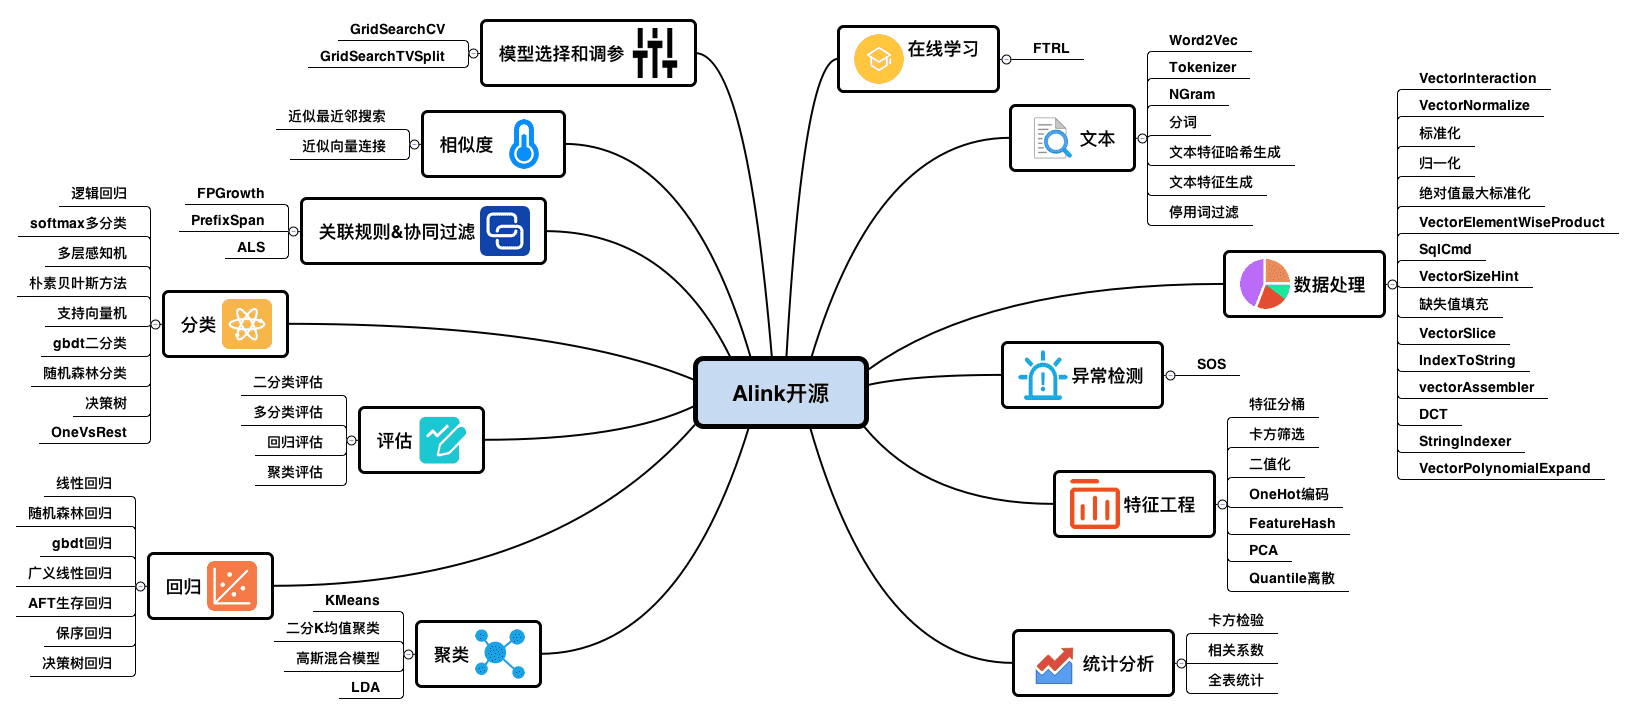

我们主要关注这几部分：

* 数据处理
* 特征加工
* 分类算法
* 回归算法

### OneHotLabel

独热编码，训练与预测。
参数略微复杂。

In [24]:
data = np.array([
    ["a", 1],
    ["b", 1],
    ["c", 1],
    ["e", 2],
    ["a", 2],
    ["b", 1],
    ["c", 2],
    ["d", 2],
    [None, 1]
])

# load data
df = pd.DataFrame({"query": data[:, 0], "label": data[:, 1]})

inOp = dataframeToOperator(df, schemaStr='query string, weight long', op_type='batch')

# one hot train
one_hot = OneHotTrainBatchOp().setSelectedCols(["query"])
model = inOp.link(one_hot)
model.print()

# batch predict
predictor = OneHotPredictBatchOp().setOutputCols(["output"]).setHandleInvalid('skip')
print(BatchOperator.collectToDataframe(predictor.linkFrom(model, inOp)))

,column_index,token,token_index
0,-1,"{""selectedCols"":""[\""query\""]"",""selectedColType...",NaN
1,0,a,0
2,0,b,1
3,0,c,2
4,0,d,3
5,0,e,4


Java type is not supported in Python for automatic conversion of values: POJO<COM.ALIBABA.ALINK.COMMON.LINALG.SPARSEVECTOR>
  query  weight    output
0     a       1  $4$0:1.0
1     b       1  $4$1:1.0
2     c       1  $4$2:1.0
3     e       2       $4$
4     a       2  $4$0:1.0
5     b       1  $4$1:1.0
6     c       2  $4$2:1.0
7     d       2  $4$3:1.0
8  None       1      None


## 2.3 机器学习
本节主要基于一个机器学习算法库alink，提供一些常用的算法。
Alink基于flink引擎，提供了多种机器学习算法，能够加速算法的训练和预测流程。


Operator（BatchOperator和StreamOperator）是Alink算法中数据的通用格式。

注：Alink Operator、pyflink Table和pandas df三者可以**两两互相转化**。
但是部分pyflink功能在alink环境中受限，所以在这个阶段我们主要使用alink功能，尽量不用pyflink的功能。


### 逻辑回归

In [25]:
data = np.array([
    [2, 1, 1],
    [3, 2, 1],
    [4, 3, 2],
    [2, 4, 1],
    [2, 2, 1],
    [4, 3, 2],
    [1, 2, 1],
    [5, 3, 3]])
df = pd.DataFrame({"f0": data[:, 0], 
                   "f1": data[:, 1],
                   "label": data[:, 2]})

batchData = dataframeToOperator(df, schemaStr='f0 int, f1 int, label int', op_type='batch')
colnames = ["f0","f1"]
lr = LinearRegTrainBatchOp().setFeatureCols(colnames).setLabelCol("label")
model = batchData.link(lr)

predictor = LinearRegPredictBatchOp().setPredictionCol("pred")
predictor.linkFrom(model, batchData).print()

,f0,f1,label,pred
0,2,1,1,1.000014
1,3,2,1,1.538474
2,4,3,2,2.076934
3,2,4,1,1.138446
4,2,2,1,1.046158
5,4,3,2,2.076934
6,1,2,1,0.553842
7,5,3,3,2.569250


### Lasso 回归算法

In [26]:
data = np.array([
    [2, 1, 1],
    [3, 2, 1],
    [4, 3, 2],
    [2, 4, 1],
    [2, 2, 1],
    [4, 3, 2],
    [1, 2, 1],
    [5, 3, 3]])
df = pd.DataFrame({"f0": data[:, 0], 
                   "f1": data[:, 1],
                   "label": data[:, 2]})

batchData = dataframeToOperator(df, schemaStr='f0 int, f1 int, label int', op_type='batch')
colnames = ["f0","f1"]
lasso = LassoRegTrainBatchOp().setLambda(0.1).setFeatureCols(colnames).setLabelCol("label")
model = batchData.link(lasso)

predictor = LassoRegPredictBatchOp().setPredictionCol("pred")
predictor.linkFrom(model, batchData).print()

,f0,f1,label,pred
0,2,1,1,1.048039
1,3,2,1,1.462233
2,4,3,2,1.876428
3,2,4,1,1.048039
4,2,2,1,1.048039
5,4,3,2,1.876428
6,1,2,1,0.633845
7,5,3,3,2.290622


### 贝叶斯算法

In [27]:
data = np.array([
    [1.0, 1.0, 0.0, 1.0, 1],
    [1.0, 0.0, 1.0, 1.0, 1],
    [1.0, 0.0, 1.0, 1.0, 1],
    [0.0, 1.0, 1.0, 0.0, 0],
    [0.0, 1.0, 1.0, 0.0, 0],
    [0.0, 1.0, 1.0, 0.0, 0],
    [0.0, 1.0, 1.0, 0.0, 0],
    [1.0, 1.0, 1.0, 1.0, 1],
    [0.0, 1.0, 1.0, 0.0, 0]])
df = pd.DataFrame({"f0": data[:, 0], 
                   "f1": data[:, 1],
                   "f2": data[:, 2],
                   "f3": data[:, 3],
                   "label": data[:, 4]})
df["label"] = df["label"].astype('int')
# train data
batchData = dataframeToOperator(df, schemaStr='f0 double, f1 double, f2 double, f3 double, label int', op_type='batch')

# train op
colnames = ["f0","f1","f2", "f3"]
ns = NaiveBayesTrainBatchOp().setFeatureCols(colnames).setLabelCol("label")
model = batchData.link(ns)
# predict op
predictor = NaiveBayesPredictBatchOp().setPredictionCol("pred")
predictor.linkFrom(model, batchData).print()

,f0,f1,f2,f3,label,pred
0,1.0,1.0,0.0,1.0,1,1
1,1.0,0.0,1.0,1.0,1,1
2,1.0,0.0,1.0,1.0,1,1
3,0.0,1.0,1.0,0.0,0,0
4,0.0,1.0,1.0,0.0,0,0
5,0.0,1.0,1.0,0.0,0,0
6,0.0,1.0,1.0,0.0,0,0
7,1.0,1.0,1.0,1.0,1,1
8,0.0,1.0,1.0,0.0,0,0


## 5. 输出



In [28]:
filePath = 'http://alink-dataset.cn-hangzhou.oss.aliyun-inc.com/csv/iris.csv'
schema = 'sepal_length double, sepal_width double, petal_length double, petal_width double, category string'
csvSource = CsvSourceBatchOp()\
    .setFilePath(filePath)\
    .setSchemaStr(schema)\
    .setFieldDelimiter(",")
csvSink = CsvSinkBatchOp()\
    .setFilePath('./dataset/alink_sink.csv')\
    .setOverwriteSink(True)

csvSource.link(csvSink)

BatchOperator.execute()